In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch

import matplotlib.pyplot as plt

import ase.io

from utils.soap import compute_spherical_expansion_librascal, PowerSpectrum
from utils.gap import train_gap_model
from utils.alchemical import AlchemicalCombine

torch.set_default_dtype(torch.float64)

In [2]:
frames = ase.io.read("data/elpasolites_10590.xyz", ":300")
energies = torch.tensor(np.loadtxt("data/elpasolites_10590_evpa.dat")[:300])

train_frames = frames[:250]
test_frames = frames[250:]

train_energies = energies[:250]
test_energies = energies[250:]

In [3]:
global_species = set()
for frame in frames:
    global_species.update(frame.numbers)

global_species = list(map(lambda u: int(u), global_species))

HYPERS = {
    "interaction_cutoff": 5.0,
    "max_angular": 4,
    "max_radial": 4,
    "gaussian_sigma_constant": 0.3,
    "gaussian_sigma_type": "Constant",
    "cutoff_smooth_width": 0.5,
    "radial_basis": "GTO",
    "compute_gradients": False,
    "expansion_by_species_method": "user defined",
    "global_species": global_species,
}

In [4]:
train_spherical_expansions, train_slices = compute_spherical_expansion_librascal(train_frames, HYPERS)
test_spherical_expansions, test_slices = compute_spherical_expansion_librascal(test_frames, HYPERS)

train_species = torch.hstack([torch.tensor(frame.numbers) for frame in train_frames])
test_species = torch.hstack([torch.tensor(frame.numbers) for frame in test_frames])

# Baseline: standard GAP model

In [5]:
class BaseGap(torch.nn.Module):
    def __init__(self, n_support, zeta, lambdas):
        super().__init__()
        self.power_spectrum = PowerSpectrum()

        self.n_support = n_support
        self.zeta = zeta
        self.lambdas = lambdas

        self.model = None

    def fit(self, spherical_expansion, all_species, structures_slices, energies):
        power_spectrum = self.power_spectrum(spherical_expansion)

        self.model = train_gap_model(
            power_spectrum, 
            all_species,
            structures_slices,
            energies, 
            self.n_support, 
            zeta=self.zeta, 
            lambdas=self.lambdas
        )

    def forward(self, spherical_expansion, all_species, structures_slices):
        ps = self.power_spectrum(spherical_expansion)
        return self.model(ps, all_species, structures_slices)

In [6]:
n_support = {
    species: 3 for species in global_species
}

base_model = BaseGap(n_support, zeta=2, lambdas=[1e-6, 1e-6])
base_model.fit(train_spherical_expansions, train_species, train_slices, train_energies)

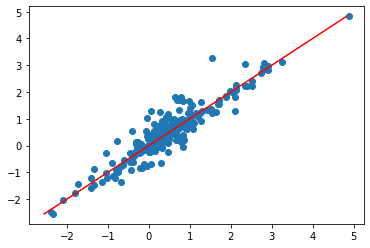

In [7]:
predicted_energies_training_set = base_model(
    train_spherical_expansions, train_species, train_slices
)

plt.scatter(predicted_energies_training_set.numpy(), train_energies)

x = np.linspace(train_energies.min(), train_energies.max(), 20)
plt.plot(x, x, color='r')

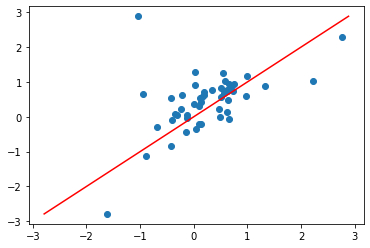

In [8]:
predicted_energies_test_set = base_model(
    test_spherical_expansions, test_species, test_slices
)

plt.scatter(predicted_energies_test_set.numpy(), test_energies)

x = np.linspace(test_energies.min(), test_energies.max(), 20)
plt.plot(x, x, color='r')

# Combining species

In [9]:
class MixedSpeciesGap(torch.nn.Module):
    def __init__(self, species, n_pseudo_species, n_support, zeta, lambdas):
        super().__init__()
        self.power_spectrum = PowerSpectrum()
        self.alchemical = AlchemicalCombine(species, n_pseudo_species)

        self.n_support = n_support
        self.zeta = zeta
        self.lambdas = lambdas

        self.model = None

    def fit(self, spherical_expansion, all_species, structures_slices, energies):
        combined = self.alchemical(spherical_expansion)
        power_spectrum = self.power_spectrum(combined)
        
        self.model = train_gap_model(
            power_spectrum, 
            all_species,
            structures_slices,
            energies, 
            self.n_support, 
            zeta=self.zeta, 
            lambdas=self.lambdas
        )

    def forward(self, spherical_expansion, all_species, structures_slices):
        combined = self.alchemical(spherical_expansion)
        ps = self.power_spectrum(combined)
        return self.model(ps, all_species, structures_slices)

In [10]:
mixed_species_model = MixedSpeciesGap(global_species, n_pseudo_species=2, n_support=n_support, zeta=2, lambdas=[1e-6, 1e-6])
mixed_species_model.fit(train_spherical_expansions, train_species, train_slices, train_energies)

In [11]:
loss_fn = torch.nn.MSELoss()

initial training set loss: 0.2036514856104529


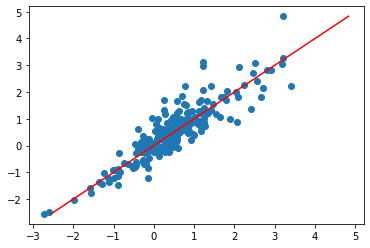

In [12]:
predicted_energies_training_set = mixed_species_model(
    train_spherical_expansions, train_species, train_slices
)

loss = loss_fn(predicted_energies_training_set.squeeze(), train_energies)
print("initial training set loss:", loss.item())

plt.scatter(predicted_energies_training_set.detach().numpy(), train_energies)

x = np.linspace(train_energies.min(), train_energies.max(), 20)
plt.plot(x, x, color='r')

initial test set loss: 0.5739604895404321


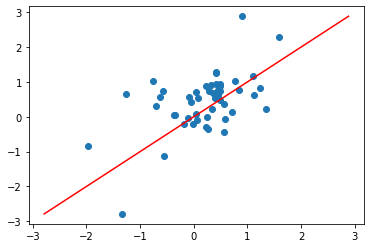

In [13]:
predicted_energies_test_set = mixed_species_model(
    test_spherical_expansions, test_species, test_slices
)

loss = loss_fn(predicted_energies_test_set.squeeze(), test_energies)
print("initial test set loss:", loss.item())

plt.scatter(predicted_energies_test_set.detach().numpy(), test_energies)

x = np.linspace(test_energies.min(), test_energies.max(), 20)
plt.plot(x, x, color='r')

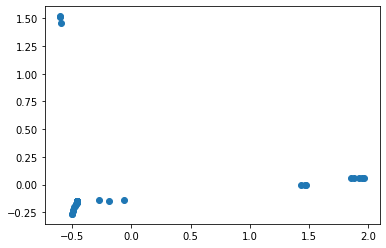

In [14]:
species_combining_matrix = mixed_species_model.alchemical.combining_matrix.detach().numpy()


plt.scatter(species_combining_matrix[:, 0], species_combining_matrix[:, 1])

In [15]:
# tentative optimization loop for the species projection

optimizer = torch.optim.AdamW(mixed_species_model.parameters(), lr=0.1)
loss_fn = torch.nn.MSELoss()

for epoch in range(20):
    optimizer.zero_grad()

    mixed_species_model.fit(train_spherical_expansions, train_species, train_slices, train_energies)
    predicted = mixed_species_model(
        train_spherical_expansions, train_species, train_slices
    )    

    loss = loss_fn(predicted.squeeze(), train_energies)

    if epoch % 1 == 0:
        print(epoch, loss.item())

    loss.backward()
    optimizer.step()


0 0.2036514856104529
1 0.18102953964836974
2 0.1687096910697489
3 0.19084349811364723
4 0.1532541035081807
5 0.13278699070833969
6 0.12333257792581967
7 0.11014763414561501
8 0.11821695307630917
9 0.1267973015558904
10 0.12435948326890173
11 0.13941635388283946
12 0.13476816479269274
13 0.10301326696338685
14 0.10457992620699565
15 0.09827222082407919
16 0.09568260705138099
17 0.1035325568335572
18 0.09545655502560857
19 0.08889333086178418


optimized training set loss: 0.08600637080497314


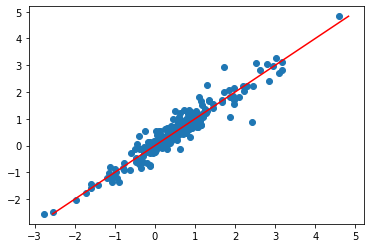

In [16]:
predicted_energies_training_set = mixed_species_model(
    train_spherical_expansions, train_species, train_slices
)

loss = loss_fn(predicted_energies_training_set.squeeze(), train_energies)
print("optimized training set loss:", loss.item())

plt.scatter(predicted_energies_training_set.detach().numpy(), train_energies)

x = np.linspace(train_energies.min(), train_energies.max(), 20)
plt.plot(x, x, color='r')

optimized test set loss: 0.4299060836044759


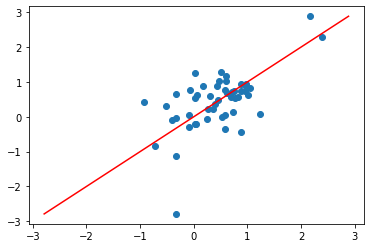

In [17]:
predicted_energies_test_set = mixed_species_model(
    test_spherical_expansions, test_species, test_slices
)

loss = loss_fn(predicted_energies_test_set.squeeze(), test_energies)
print("optimized test set loss:", loss.item())

plt.scatter(predicted_energies_test_set.detach().numpy(), test_energies)

x = np.linspace(test_energies.min(), test_energies.max(), 20)
plt.plot(x, x, color='r')

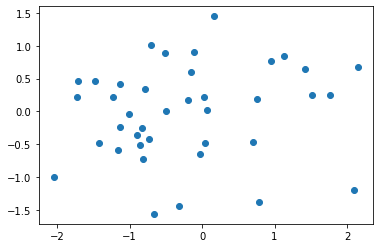

In [18]:
species_combining_matrix = mixed_species_model.alchemical.combining_matrix.detach().numpy()

plt.scatter(species_combining_matrix[:, 0], species_combining_matrix[:, 1])